In [1]:
# Cell 1: Imports and setup
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

print("Setting up environment...")

Setting up environment...


In [2]:
# Cell 2: Define angular bins and create realistic mock data
# Define the angular bins in degrees
angular_bins = [
    (0, 85),    # Near-vertical to intermediate
    (85, 100),  # Near-horizontal
    (100, 120), # Horizontal to upward-going
    (120, 180)  # Upward-going through Earth
]

# Create representative angles from each bin
representative_angles = []
for bin_min, bin_max in angular_bins:
    # Add start, middle, and end points from each bin
    points = [bin_min, (bin_min + bin_max) / 2, bin_max]
    for point in points:
        if point not in representative_angles and point <= 180:
            representative_angles.append(point)

representative_angles = sorted(representative_angles)
print("Angular bins:", angular_bins)
print("Representative angles:", representative_angles)
print("Cosine values:", [f"{np.cos(np.deg2rad(angle)):.3f}" for angle in representative_angles])

# Create energy grid
energy = np.logspace(2, 7, 100)  # 100 GeV to 10 PeV

Angular bins: [(0, 85), (85, 100), (100, 120), (120, 180)]
Representative angles: [0, 42.5, 85, 92.5, 100, 110.0, 120, 150.0, 180]
Cosine values: ['1.000', '0.737', '0.087', '-0.044', '-0.174', '-0.342', '-0.500', '-0.866', '-1.000']


In [3]:
# Cell 3: Create realistic mock data for H3a and H4a models
def create_realistic_mock_fluxes(energy, angles, model_type='H3a'):
    """
    Create realistic mock atmospheric electron neutrino fluxes
    based on known physics of H3a vs H4a models and angular dependence
    """
    fluxes = {}
    
    # Model differences: H4a has more heavy primaries than H3a
    if model_type == 'H3a':
        # H3a: Mixed composition, moderate prompt component
        base_norm = 1.0
        prompt_strength = 0.3
        energy_dep_factor = 1.0
    else:  # H4a
        # H4a: More heavy primaries, stronger prompt component
        base_norm = 0.9  # Slightly lower conventional flux
        prompt_strength = 0.5  # Stronger prompt component
        energy_dep_factor = 1.2  # More energy-dependent
    
    for angle in angles:
        cos_theta = np.cos(np.deg2rad(angle))
        
        # Base conventional flux (typical atmospheric neutrino spectrum)
        # E^-3.7 spectrum with knee and ankle features
        base_flux = 1e-2 * energy**(-3.7) * (1 + (energy/1e5)**0.5)
        
        # Angular dependence factors
        if angle <= 85:  # Downward-going
            # Short path length, minimal Earth absorption
            path_factor = 1.0 / max(0.1, cos_theta)  # ~1-3x
            earth_absorption = 1.0  # No Earth absorption
            prompt_angle_factor = 1.0
            
        elif angle <= 100:  # Near-horizontal
            # Long atmospheric path
            path_factor = 5.0 + 5.0 * (1 - cos_theta)
            earth_absorption = 1.0  # No Earth absorption
            prompt_angle_factor = 2.0  # Enhanced prompt at horizon
            
        elif angle <= 120:  # Upward-going
            # Through atmosphere and shallow Earth
            path_factor = 10.0 + 10.0 * (1 - cos_theta)
            earth_absorption = 0.8  # Some Earth absorption
            prompt_angle_factor = 1.5
            
        else:  # Through Earth (120-180°)
            # Significant Earth absorption
            path_length = 180 - angle  # Simplified Earth traversal
            path_factor = 15.0
            earth_absorption = 0.3 + 0.5 * (angle - 120) / 60  # 0.3 to 0.8
            prompt_angle_factor = 1.2
        
        # Conventional flux (without prompt)
        conv_flux = (base_flux * path_factor * earth_absorption * base_norm)
        
        # Prompt flux (energy-dependent, enhanced in H4a)
        prompt_flux = (base_flux * prompt_strength * prompt_angle_factor * 
                      (energy/1e4)**energy_dep_factor * base_norm)
        
        # Total flux (conventional + prompt)
        total_flux = conv_flux + prompt_flux
        
        fluxes[angle] = {
            'nue_conv': conv_flux,
            'nue_total': total_flux,
            'cos_theta': cos_theta,
            'energy': energy
        }
    
    return fluxes

print("Creating mock H3a data...")
h3a_data = create_realistic_mock_fluxes(energy, representative_angles, 'H3a')

print("Creating mock H4a data...")
h4a_data = create_realistic_mock_fluxes(energy, representative_angles, 'H4a')

print("Mock data creation completed!")

Creating mock H3a data...
Creating mock H4a data...
Mock data creation completed!


In [4]:
# Cell 4: Calculate flux ratios and organize by angular bins
def get_angular_bin(angle):
    """Determine which angular bin the angle belongs to"""
    for bin_min, bin_max in angular_bins:
        if bin_min <= angle <= bin_max:
            return (bin_min, bin_max)
    return None

def calculate_ratios(flux_data):
    """Calculate flux ratios relative to angular average"""
    angles = list(flux_data.keys())
    
    # Calculate angular average fluxes
    total_avg = np.mean([flux_data[angle]['nue_total'] for angle in angles], axis=0)
    conv_avg = np.mean([flux_data[angle]['nue_conv'] for angle in angles], axis=0)
    
    # Calculate ratios for each angle
    ratios = {}
    for angle in angles:
        ratios[angle] = {
            'total_ratio': flux_data[angle]['nue_total'] / total_avg,
            'conv_ratio': flux_data[angle]['nue_conv'] / conv_avg,
            'cos_theta': flux_data[angle]['cos_theta'],
            'angular_bin': get_angular_bin(angle)
        }
    
    return ratios

# Calculate ratios for both models
h3a_ratios = calculate_ratios(h3a_data)
h4a_ratios = calculate_ratios(h4a_data)

print("Flux ratio calculation completed!")

# Display some statistics
print(f"\nModel Comparison Summary:")
print(f"H3a - Conventional flux range: {np.min([h3a_data[a]['nue_conv'][50] for a in representative_angles]):.2e} to {np.max([h3a_data[a]['nue_conv'][50] for a in representative_angles]):.2e}")
print(f"H4a - Conventional flux range: {np.min([h4a_data[a]['nue_conv'][50] for a in representative_angles]):.2e} to {np.max([h4a_data[a]['nue_conv'][50] for a in representative_angles]):.2e}")

Flux ratio calculation completed!

Model Comparison Summary:
H3a - Conventional flux range: 2.85e-19 to 5.70e-18
H4a - Conventional flux range: 2.57e-19 to 5.13e-18


Saving plots to: /Users/gadha/Desktop
Main comparison plot saved to: /Users/gadha/Desktop/electron_neutrino_angular_flux_comparison.png


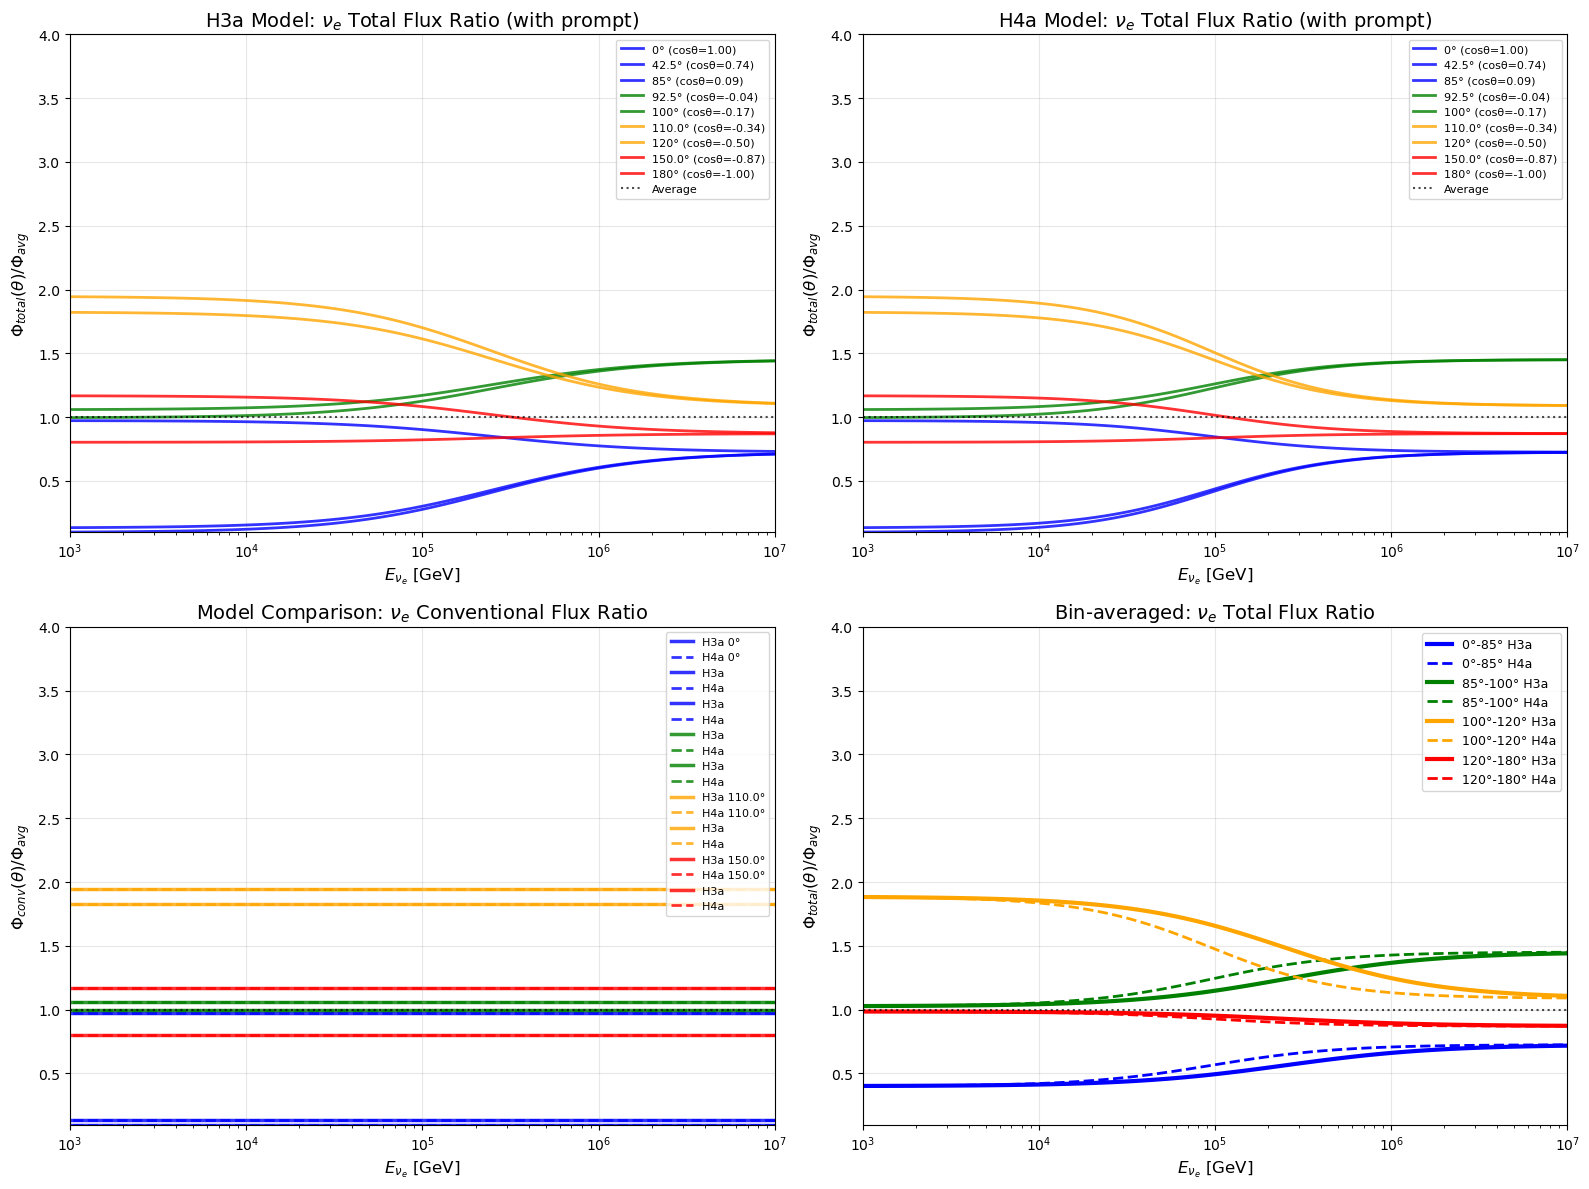

In [13]:
# Cell 5: Create comprehensive comparison plots and save to desktop
import matplotlib.pyplot as plt
import os

# Get desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
print(f"Saving plots to: {desktop_path}")

# Color scheme for angular bins
bin_colors = {
    (0, 85): 'blue',
    (85, 100): 'green', 
    (100, 120): 'orange',
    (120, 180): 'red'
}

bin_labels = {
    (0, 85): 'Downward (0°-85°)',
    (85, 100): 'Near-horizontal (85°-100°)', 
    (100, 120): 'Upward (100°-120°)',
    (120, 180): 'Through Earth (120°-180°)'
}

# Create the main comparison figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: H3a Model - Total Flux Ratios
for angle in representative_angles:
    angular_bin = h3a_ratios[angle]['angular_bin']
    color = bin_colors[angular_bin]
    cos_theta = h3a_ratios[angle]['cos_theta']
    
    label = f'{angle}° (cosθ={cos_theta:.2f})'
    
    ax1.plot(energy, h3a_ratios[angle]['total_ratio'], 
             color=color, linestyle='-', linewidth=2, alpha=0.8,
             label=label)

ax1.axhline(1.0, color='black', linestyle=':', alpha=0.7, label='Average')
ax1.set_xscale('log')
ax1.set_yscale('linear')
ax1.set_xlim(1e3, 1e7)
ax1.set_ylim(0.1, 4)
ax1.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=12)
ax1.set_ylabel(r'$\Phi_{total}(\theta) / \Phi_{avg}$', fontsize=12)
ax1.set_title(r'H3a Model: $\nu_e$ Total Flux Ratio (with prompt)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8, loc='upper right')

# Plot 2: H4a Model - Total Flux Ratios
for angle in representative_angles:
    angular_bin = h4a_ratios[angle]['angular_bin']
    color = bin_colors[angular_bin]
    cos_theta = h4a_ratios[angle]['cos_theta']
    
    label = f'{angle}° (cosθ={cos_theta:.2f})'
    
    ax2.plot(energy, h4a_ratios[angle]['total_ratio'], 
             color=color, linestyle='-', linewidth=2, alpha=0.8,
             label=label)

ax2.axhline(1.0, color='black', linestyle=':', alpha=0.7, label='Average')
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_xlim(1e3, 1e7)
ax2.set_ylim(0.1, 4)
ax2.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=12)
ax2.set_ylabel(r'$\Phi_{total}(\theta) / \Phi_{avg}$', fontsize=12)
ax2.set_title(r'H4a Model: $\nu_e$ Total Flux Ratio (with prompt)', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8, loc='upper right')

# Plot 3: H3a vs H4a Comparison - Conventional Flux
for angle in representative_angles:
    angular_bin = h3a_ratios[angle]['angular_bin']
    color = bin_colors[angular_bin]
    
    # Only label one angle per bin to reduce clutter
    label = f'{angle}°' if angle in [0, 90, 110, 150] else ""
    
    ax3.plot(energy, h3a_ratios[angle]['conv_ratio'], 
             color=color, linestyle='-', linewidth=2.5, alpha=0.8,
             label=f'H3a {label}')
    
    ax3.plot(energy, h4a_ratios[angle]['conv_ratio'],
             color=color, linestyle='--', linewidth=2, alpha=0.8,
             label=f'H4a {label}')

ax3.axhline(1.0, color='black', linestyle=':', alpha=0.7)
ax3.set_xscale('log')
ax3.set_yscale('linear')
ax3.set_xlim(1e3, 1e7)
ax3.set_ylim(0.1, 4)
ax3.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=12)
ax3.set_ylabel(r'$\Phi_{conv}(\theta) / \Phi_{avg}$', fontsize=12)
ax3.set_title(r'Model Comparison: $\nu_e$ Conventional Flux Ratio', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=8, loc='upper right')

# Plot 4: Angular Bin Summary
for angular_bin in angular_bins:
    color = bin_colors[angular_bin]
    bin_min, bin_max = angular_bin
    
    # Get angles in this bin
    angles_in_bin = [a for a in representative_angles if get_angular_bin(a) == angular_bin]
    
    if angles_in_bin:
        # Plot average ratio for this bin
        avg_h3a = np.mean([h3a_ratios[angle]['total_ratio'] for angle in angles_in_bin], axis=0)
        avg_h4a = np.mean([h4a_ratios[angle]['total_ratio'] for angle in angles_in_bin], axis=0)
        
        ax4.plot(energy, avg_h3a, color=color, linestyle='-', linewidth=3,
                label=f'{bin_min}°-{bin_max}° H3a')
        ax4.plot(energy, avg_h4a, color=color, linestyle='--', linewidth=2,
                label=f'{bin_min}°-{bin_max}° H4a')

ax4.axhline(1.0, color='black', linestyle=':', alpha=0.7)
ax4.set_xscale('log')
ax4.set_yscale('linear')
ax4.set_xlim(1e3, 1e7)
ax4.set_ylim(0.1, 4)
ax4.set_xlabel(r'$E_{\nu_e}$ [GeV]', fontsize=12)
ax4.set_ylabel(r'$\Phi_{total}(\theta) / \Phi_{avg}$', fontsize=12)
ax4.set_title(r'Bin-averaged: $\nu_e$ Total Flux Ratio', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=9, loc='upper right')

plt.tight_layout()

# Save the main comparison plot
main_plot_path = os.path.join(desktop_path, "electron_neutrino_angular_flux_comparison.png")
plt.savefig(main_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Main comparison plot saved to: {main_plot_path}")

plt.show()